In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and stability calculation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Do unfolding

In [6]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    Data_unfolded.SetMarkerStyle(22)
    Data_unfolded.SetMarkerColor(1)
    Data_unfolded.SetLineColor(1)
    Data_unfolded.SetLineWidth(2)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    hs.Add(Data_unfolded,"E")
    
    leg=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded,"Data_unfolded",'p')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    return hs,ratio,leg

# $\tau_4^{(0.5)}$

In [7]:
reco='recoJet_tau_0p5_4_WTA_kT_nom_dijetSel'
gen='genJet_tau_0p5_4_WTA_kT_dijetSel'
response='respJet_tau_0p5_4_WTA_kT_nom_dijetSel'

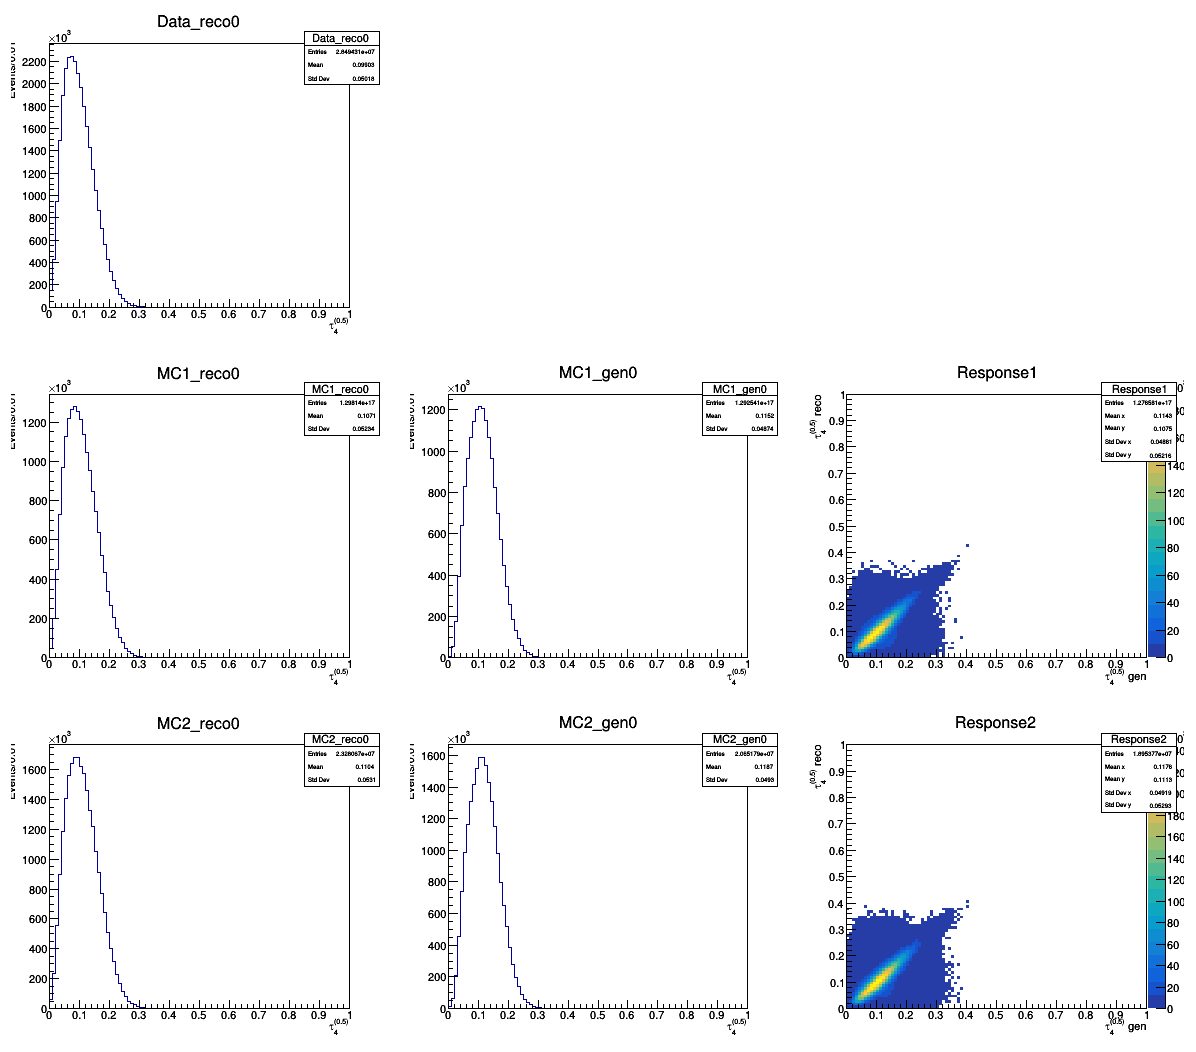

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{4}^{(0.5)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{4}^{(0.5)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{4}^{(0.5)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{4}^{(0.5)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{4}^{(0.5)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{4}^{(0.5)} gen;#tau_{4}^{(0.5)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{4}^{(0.5)} gen;#tau_{4}^{(0.5)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [9]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 11475.36835 44666.5042695
0.015 61723.3147877 182489.311583
0.025 198803.154046 430036.408514
0.035 438115.9619 704558.05674
0.045 700442.445938 937486.734329
0.055 937826.40335 1124029.67803
0.065 1103936.22941 1241823.41944
0.075 1236643.30745 1327475.5227
0.085 1322852.80402 1358676.67151
0.095 1408668.06518 1369760.07729
0.105 1466465.54407 1327693.59533
0.115 1458549.41556 1292633.34825
0.125 1406500.6016 1202718.57388
0.135 1307061.72248 1099061.09731
0.145 1188669.91283 1001158.23058
0.155 1042494.77528 867201.930588
0.165 879510.586377 755831.304262
0.175 721062.552084 638643.621308
0.185 587611.585431 537654.669513
0.195 460344.687285 418640.476375
0.205 341085.894735 330430.907086
0.215 249683.989217 260408.319666
0.225 172577.416451 183965.709378
0.235 122030.719661 134836.621096
0.245 75931.5386206 89004.5418514
0.255 49362.1463796 64168.6309282
0.265 36613.8193494 41504.058561
0.275 21540.9974561 28558.7026102
0.285 13097.4429507 19821.9234541
0.295 7464.43517223 948

# Different bins

In [10]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.3)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.41])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.3)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.35,0.41])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.32)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.41])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.32)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.36,0.41])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.3)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.41])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.3)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.35,0.41])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.32)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.41])))
reco_bins1=np.array([x for x in np.linspace(num=17,start=0,stop=0.32)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.36,0.41])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=18,start=0.,stop=0.34)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.41])))
reco_bins1=np.array([x for x in np.linspace(num=35,start=0.,stop=0.34)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.37,0.41])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.1  0.2  0.3  0.41] 4
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.41] 8
[0.   0.08 0.16 0.24 0.32 0.41] 5
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.41] 10
[0.   0.06 0.12 0.18 0.24 0.3  0.41] 6
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.35 0.41] 12
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.41] 9
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.36 0.41] 18
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.41] 18
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.37 0.41] 36


In [11]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{4}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{4}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{4}^{(0.5)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{4}^{(0.5)} gen;#tau_{4}^{(0.5)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{4}^{(0.5)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{4}^{(0.5)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{4}^{(0.5)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.1  0.2  0.3  0.41]
for binning 2
[0.   0.08 0.16 0.24 0.32 0.41]
for binning 3
[0.   0.06 0.12 0.18 0.24 0.3  0.41]
for binning 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.41]
for binning 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.41]


Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{4}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{4}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{4}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{4}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in <

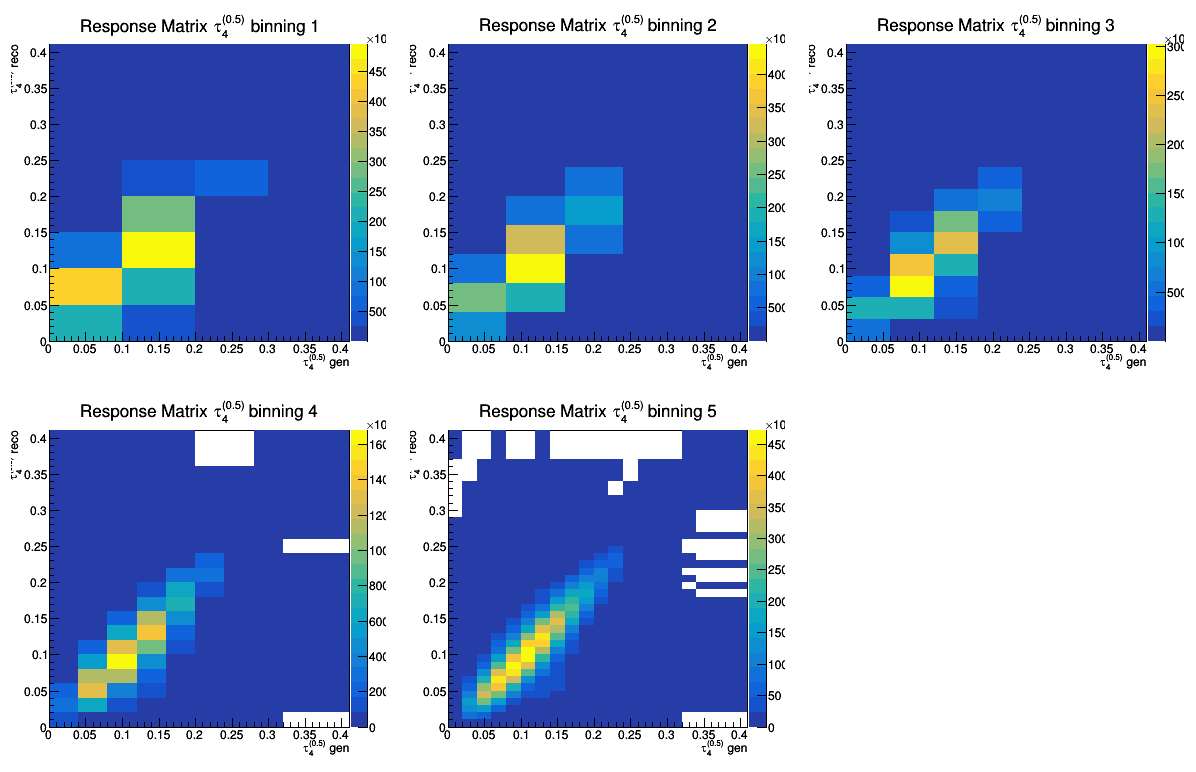

In [12]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


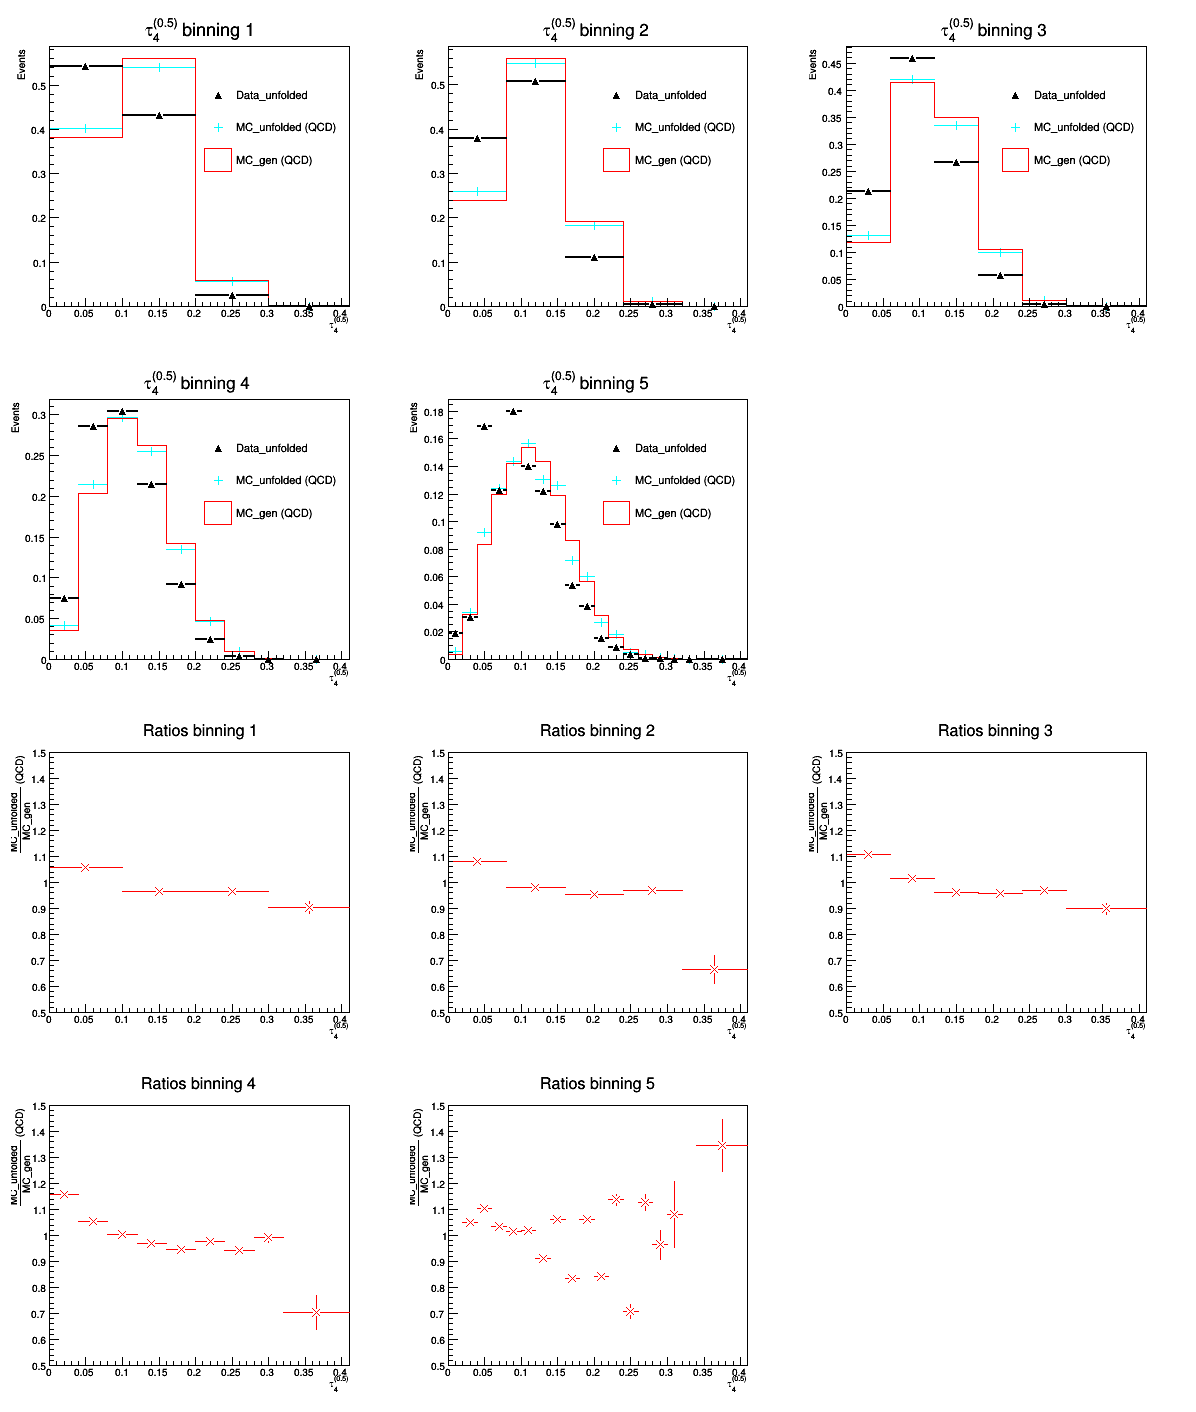

In [13]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{4}^{(0.5)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

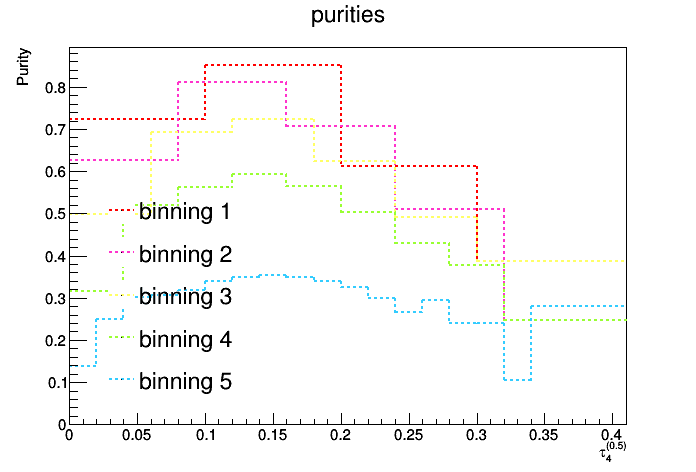

In [14]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{4}^{(0.5)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

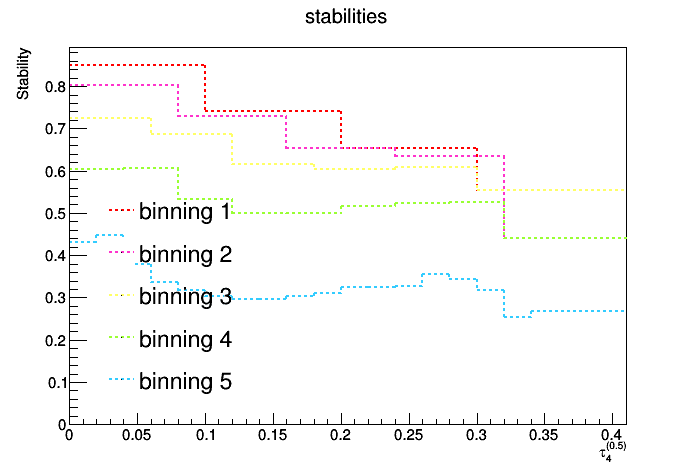

In [15]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{4}^{(0.5)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

# $\tau_{4}^{(1)}$

In [16]:
reco='recoJet_tau_1_4_WTA_kT_nom_dijetSel'
gen='genJet_tau_1_4_WTA_kT_dijetSel'
response='respJet_tau_1_4_WTA_kT_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


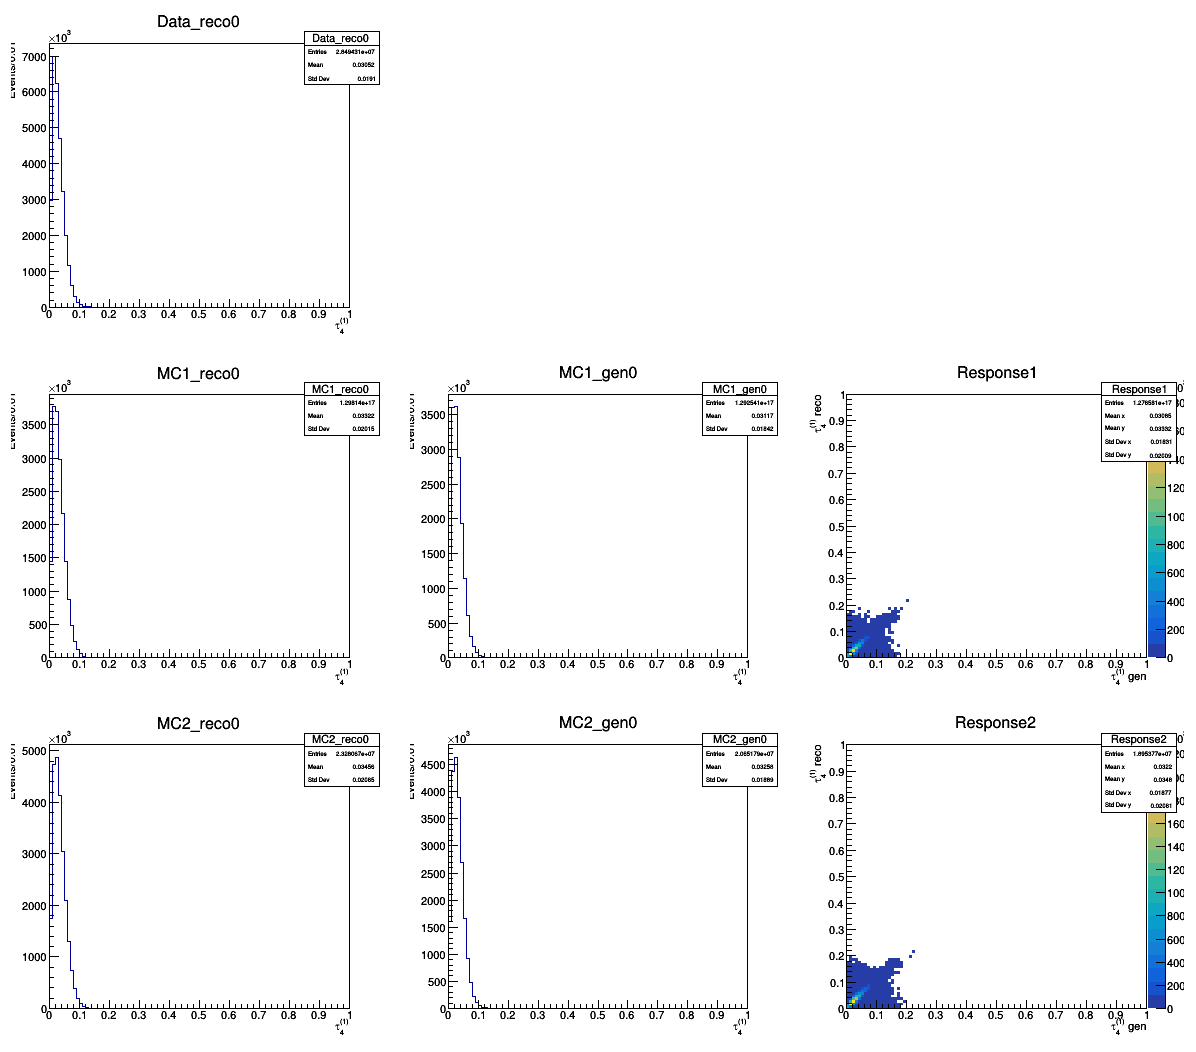

In [17]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{4}^{(1)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{4}^{(1)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{4}^{(1)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{4}^{(1)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{4}^{(1)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{4}^{(1)} gen;#tau_{4}^{(1)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{4}^{(1)} gen;#tau_{4}^{(1)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [18]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 1528622.7358 1379100.73281
0.015 4121841.45938 3782406.2941
0.025 4295681.431 3958661.75389
0.035 3554840.15628 3380913.97641
0.045 2428731.76357 2514174.35841
0.055 1491716.58135 1718844.04157
0.065 815428.183162 1074646.27242
0.075 423047.405513 614190.798072
0.085 203038.961858 316660.540335
0.095 90839.1048475 157885.979676
0.105 47080.9070429 76546.5688792
0.115 21078.8086102 36651.3403375
0.125 9588.57459153 14882.9969703
0.135 3014.22986971 7347.02716911
0.145 1088.74135382 2316.48980884
0.155 512.190248237 1002.63146774
0.165 334.769952797 312.100271978
0.175 231.973660565 35.018515878
0.185 16.3886232586 152.879329126
0.195 0.13412654632 3.92683163988
0.205 0.0 0.0
0.215 1.22642897088 73.5461355729
0.225 73.5461355729 0.0
0.235 0.0 0.0
0.245 0.0 0.0
0.255 0.0 0.0
0.265 0.0 0.0
0.275 0.0 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.0 0.0
0.355 0.0 0.0
0.365 0.0 0.0
0.375 0.0 0.0
0.385 0.0 0.0
0.395 0.0 0.0
0.405 0.0 0.0
0

In [19]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=2,start=0.,stop=0.08)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.23])))
reco_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.08)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.15,0.23])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.12)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.23])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.12)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.17,0.23])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.16)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.23])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.16)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.19,0.23])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.16)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.23])))
reco_bins1=np.array([x for x in np.linspace(num=17,start=0.,stop=0.16)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.19,0.23])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.08 0.23] 2
[0.   0.04 0.08 0.15 0.23] 4
[0.   0.06 0.12 0.23] 3
[0.   0.03 0.06 0.09 0.12 0.17 0.23] 6
[0.   0.04 0.08 0.12 0.16 0.23] 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.19 0.23] 10
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.23] 9
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.19 0.23] 18


In [21]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{4}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{4}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{4}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{4}^{(1)} gen;#tau_{4}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{4}^{(1)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{4}^{(1)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{4}^{(1)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.08 0.23]
for binning 2
[0.   0.06 0.12 0.23]
for binning 3
[0.   0.04 0.08 0.12 0.16 0.23]
for binning 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.23]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 4 input bins and 2 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{4}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #3 (xaxis:#tau_{4}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

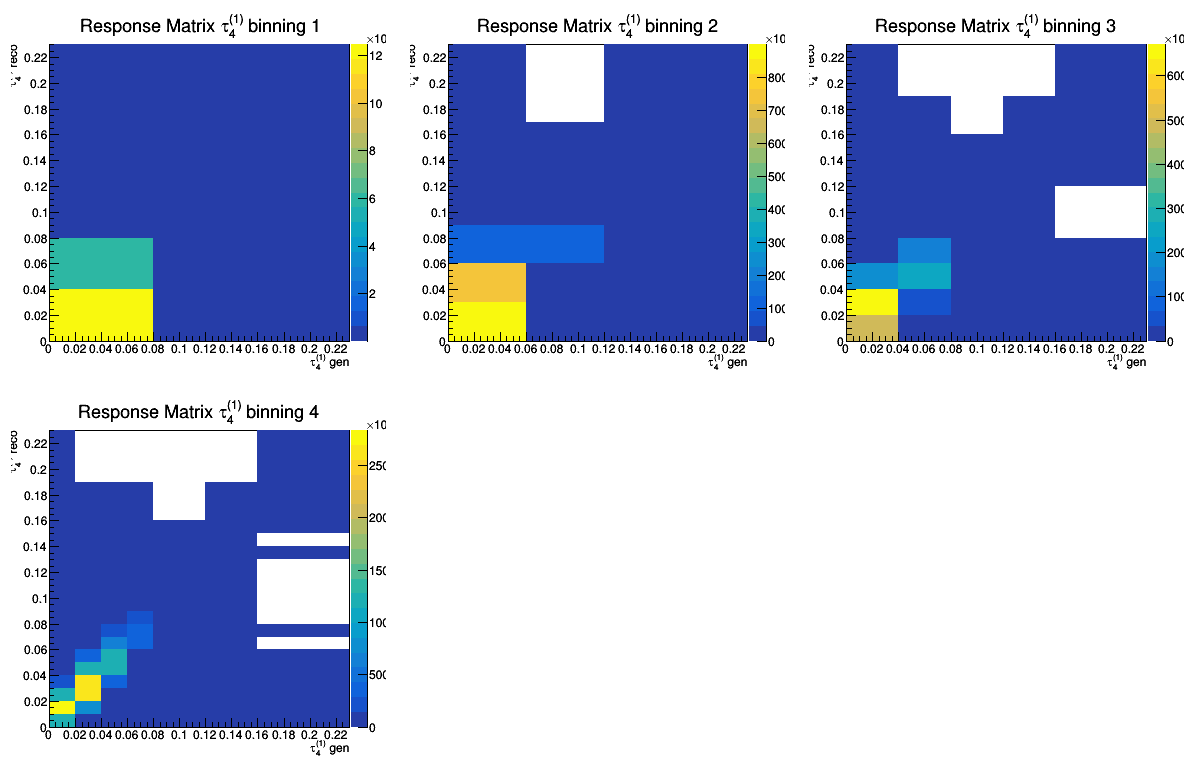

In [22]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


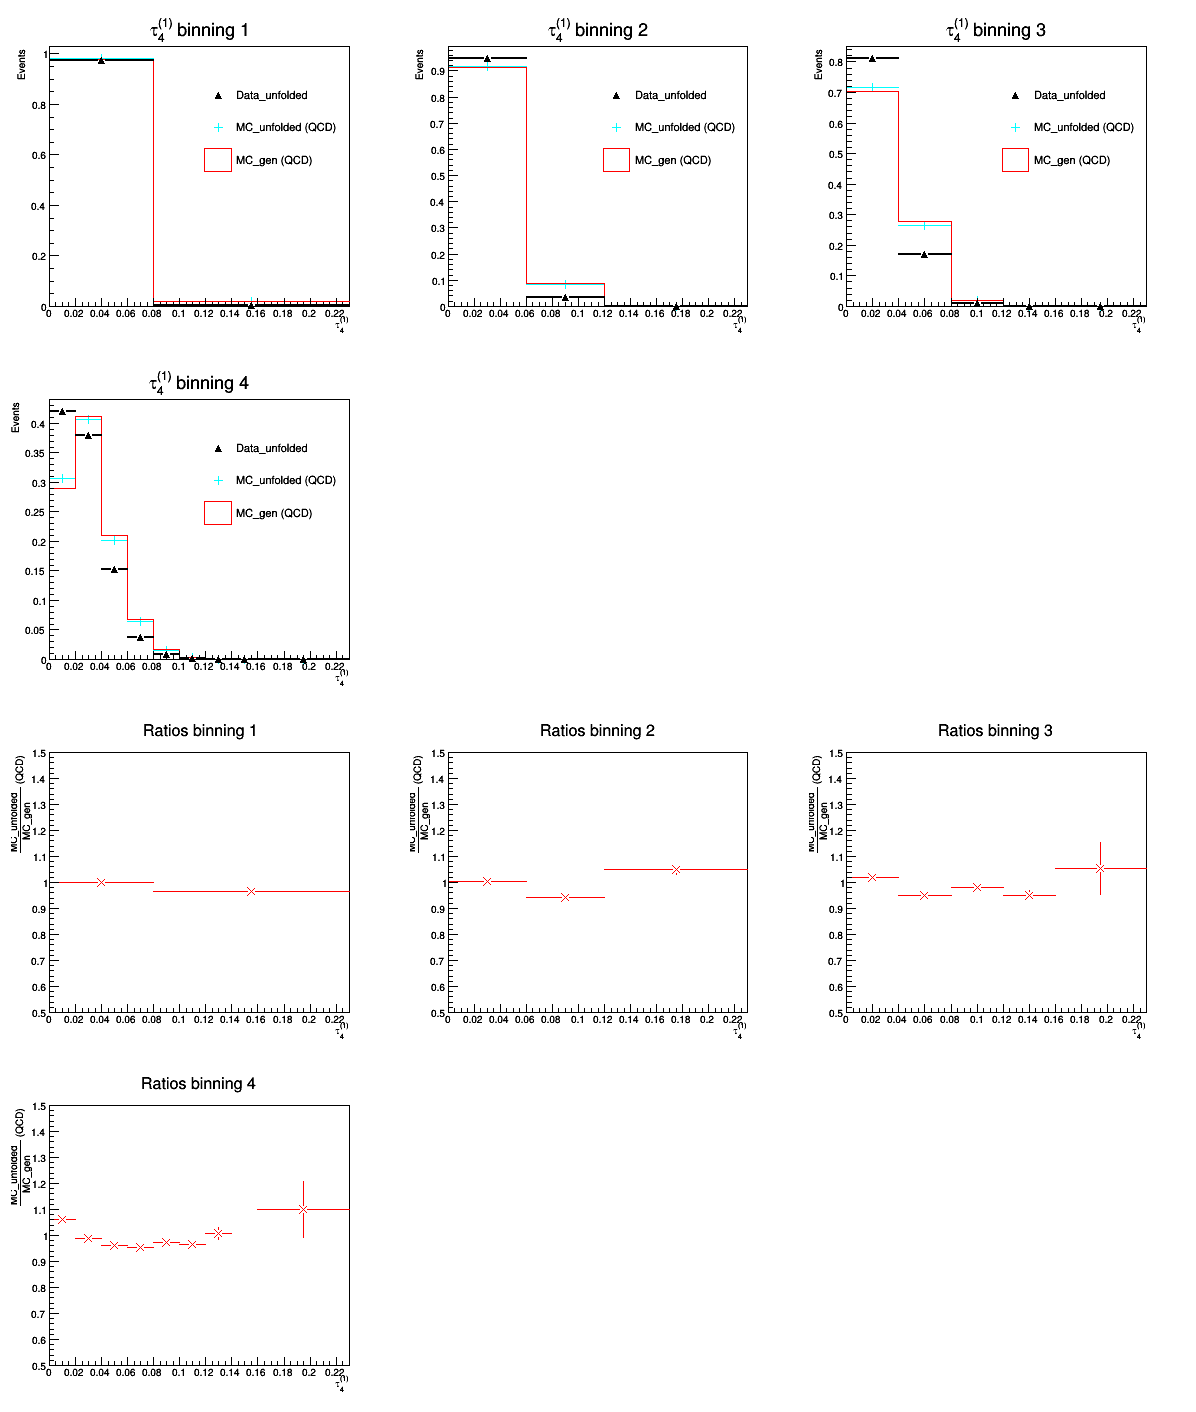

In [23]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{4}^{(1)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,len(gen_bins)+6):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

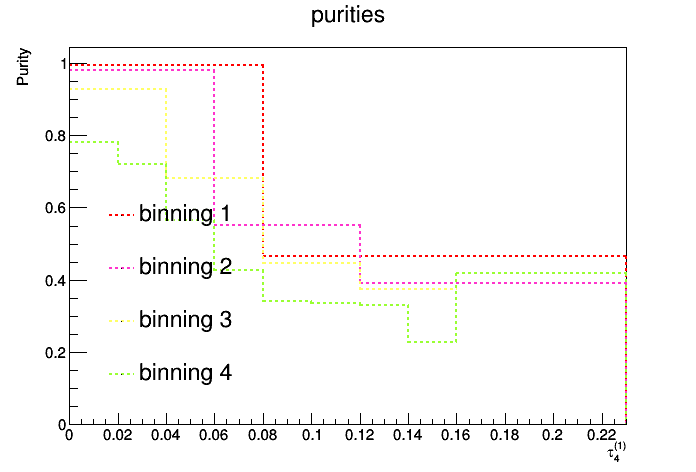

In [24]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{4}^{(1)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

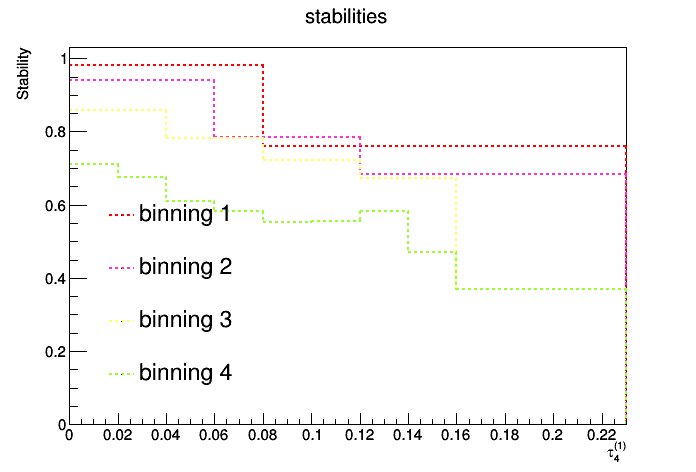

In [25]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{4}^{(1)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

# $\tau_4^{(2)}$

In [27]:
reco='recoJet_tau_2_4_WTA_kT_nom_dijetSel'
gen='genJet_tau_2_4_WTA_kT_dijetSel'
response='respJet_tau_2_4_WTA_kT_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


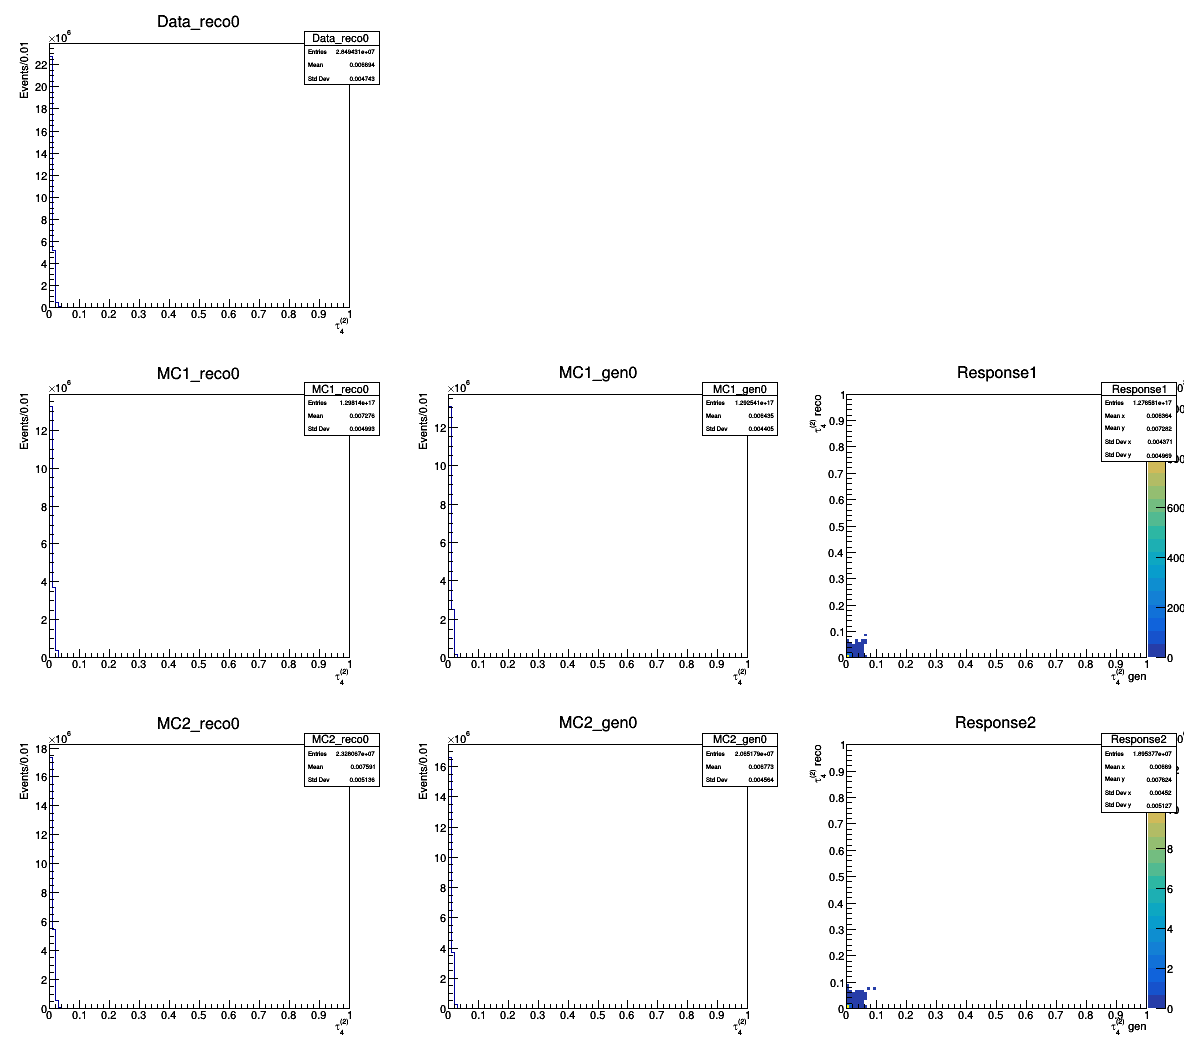

In [28]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{4}^{(2)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{4}^{(2)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{4}^{(2)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{4}^{(2)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{4}^{(2)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{4}^{(2)} gen;#tau_{4}^{(2)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{4}^{(2)} gen;#tau_{4}^{(2)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [29]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 15419830.2124 14055225.45
0.015 3327873.96197 4469887.82694
0.025 258753.624361 462004.092752
0.035 26882.2943965 44892.3252831
0.045 2353.49902988 3498.30302866
0.055 545.924456825 608.053111535
0.065 43.6038376818 161.983565126
0.075 2.64497946061 78.359230926
0.085 0.0 2.917646271
0.095 73.5461355729 0.0
0.105 0.0 0.0
0.115 0.0 0.0
0.125 0.0 0.0
0.135 0.0 0.0
0.145 0.0 0.0
0.155 0.0 0.0
0.165 0.0 0.0
0.175 0.0 0.0
0.185 0.0 0.0
0.195 0.0 0.0
0.205 0.0 0.0
0.215 0.0 0.0
0.225 0.0 0.0
0.235 0.0 0.0
0.245 0.0 0.0
0.255 0.0 0.0
0.265 0.0 0.0
0.275 0.0 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.0 0.0
0.355 0.0 0.0
0.365 0.0 0.0
0.375 0.0 0.0
0.385 0.0 0.0
0.395 0.0 0.0
0.405 0.0 0.0
0.415 0.0 0.0
0.425 0.0 0.0
0.435 0.0 0.0
0.445 0.0 0.0
0.455 0.0 0.0
0.465 0.0 0.0
0.475 0.0 0.0
0.485 0.0 0.0
0.495 0.0 0.0
0.505 0.0 0.0
0.515 0.0 0.0
0.525 0.0 0.0
0.535 0.0 0.0
0.545 0.0 0.0
0.555 0.0 0.0
0.565 0.0 0.0
0.575 0.0 0.0
0.585 0.0 0.0

In [30]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=2,start=0.,stop=0.04)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.1])))
reco_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.04)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.07,0.1])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.06)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.1])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.06)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.08,0.1])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.04 0.1 ] 2
[0.   0.02 0.04 0.07 0.1 ] 4
[0.   0.02 0.04 0.06 0.1 ] 4
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.08 0.1 ] 8


In [31]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{4}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{4}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{4}^{(2)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{4}^{(2)} gen;#tau_{4}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{4}^{(2)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{4}^{(2)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{4}^{(2)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.04 0.1 ]
for binning 2
[0.   0.02 0.04 0.06 0.1 ]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 4 input bins and 2 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{4}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #3 (xaxis:#tau_{4}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

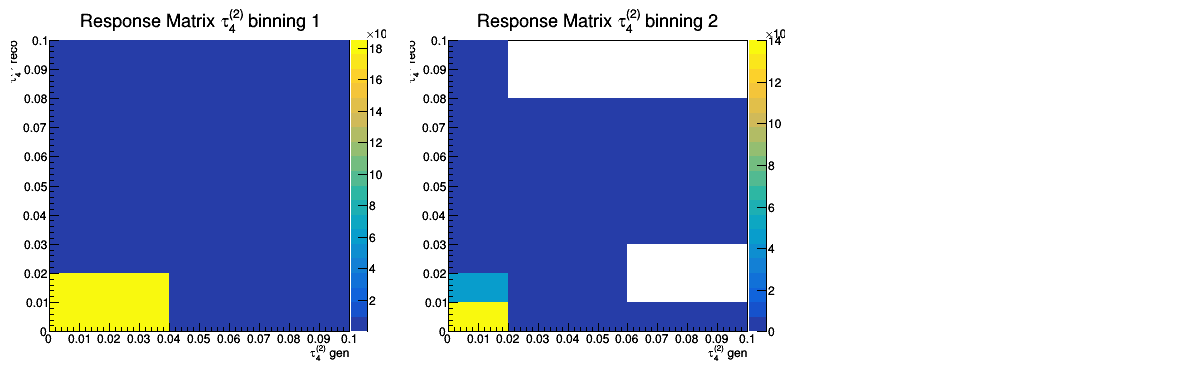

In [32]:
c=rt.TCanvas("","",0,0,1200,400)
c.Divide(3,1)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


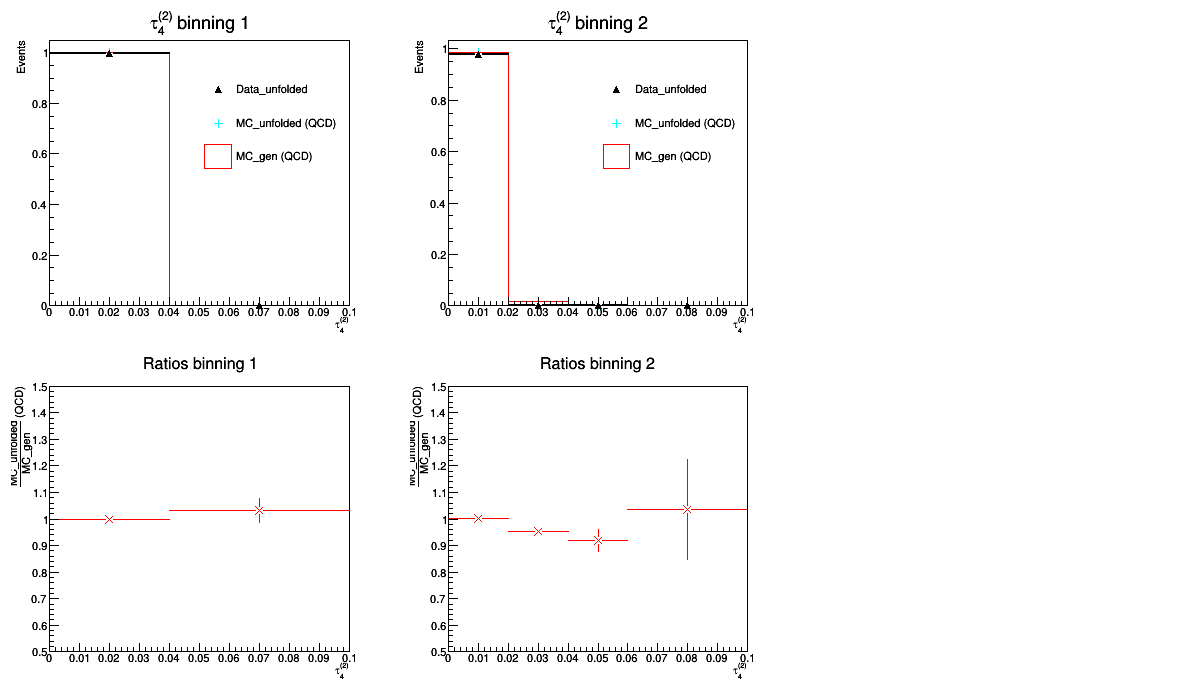

In [33]:
c=rt.TCanvas("","",0,0,1200,720)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{4}^{(2)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(3,3+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-3].Draw()
c.Draw()

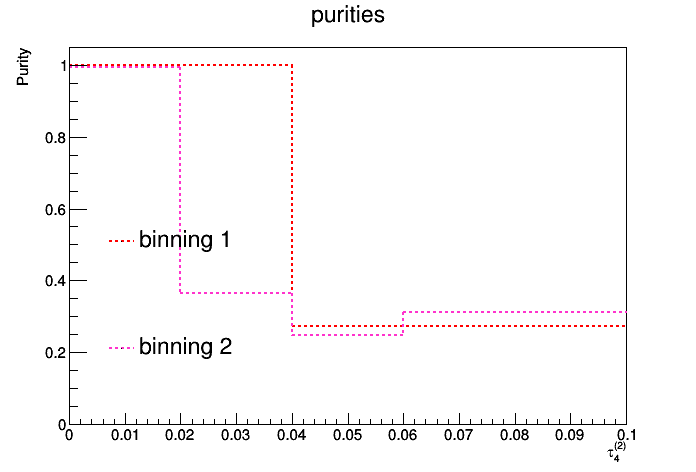

In [34]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{4}^{(2)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

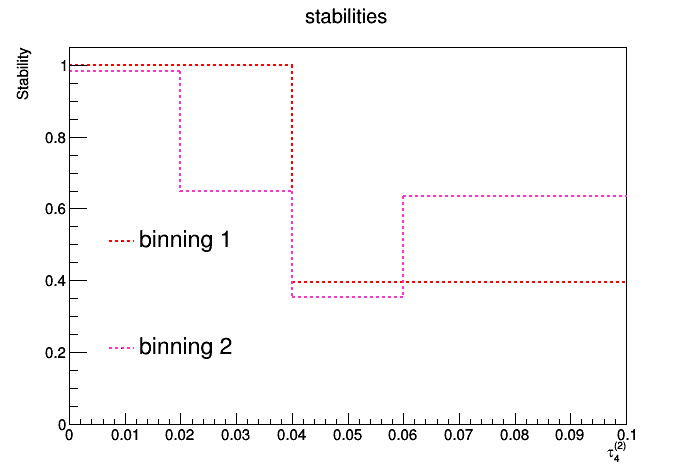

In [35]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{4}^{(2)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()